# EEGNet-LSTM

The hybrid neural network model EEGNet-LSTM, by combining the spatial and frequency feature extraction capabilities of EEGNet with the time series modeling ability of LSTM, can effectively decode spatio-temporal features from raw EEG data.

EEGNet-LSTM: [Empirical comparison of deep learning methods for EEG decoding](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.1003984/full)

EEGNet: [EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces](https://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta)

**Use the trained model in ./checkpoints to perform performance evaluation**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from model import(
    EEG_MLP,
    EEGNetRegression,
    EEGNetLSTMRegression,
)

from utils import (
    z_score_norm,
    evaluate_regression,
    train_model,
)

In [3]:
# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_MLP = EEG_MLP().to(device)
model_EEGNet = EEGNetRegression().to(device)
model_EEGNetLSTM = EEGNetLSTMRegression().to(device)

model_dir = './checkpoints_cv'
model_MLP.load_state_dict(torch.load(f'{model_dir}/eeg_mlp_best_model_fold_2_mse_0.0600.pth'))
model_EEGNet.load_state_dict(torch.load(f'{model_dir}/eegnet_best_model_fold_3_mse_0.0661.pth'))
model_EEGNetLSTM.load_state_dict(torch.load(f'{model_dir}/eegnet_lstm_best_model_fold_2_mse_0.0781.pth'))

<All keys matched successfully>

In [4]:
# Initialize the dict to store the results
eeg_mlp_dict = {}
eegnet_dict = {}
eegnet_lstm_dict = {}

# Test set

In [ ]:
# Test dataset
data_dir = '../data/data_model/sub-jimingda/aligned_data_20250311'
data_s1 = np.load(data_dir + '/20240819_jmd_aligned_1.npz')
data_s3 = np.load(data_dir + '/20240819_jmd_aligned_3.npz')
data_s5 = np.load(data_dir + '/20240819_jmd_aligned_5.npz')
data_s7 = np.load(data_dir + '/20240819_jmd_aligned_7.npz')
feature_s1, steering_s1 = data_s1['feature'], data_s1['steering']
feature_s3, steering_s3 = data_s3['feature'], data_s3['steering']
feature_s5, steering_s5 = data_s5['feature'], data_s5['steering']
feature_s7, steering_s7 = data_s7['feature'], data_s7['steering']

bend_index = np.where(abs(steering_s1) > 0.05)
# print(steering_s1[bend_index].size)

test_data_mlp = feature_s3
test_data_mlp = z_score_norm(test_data_mlp)
test_label_mlp = steering_s3

test_data_eegnet = feature_s5
test_data_eegnet = z_score_norm(test_data_eegnet)
test_label_eegnet = steering_s5

test_data_eegnet_lstm = feature_s3
test_data_eegnet_lstm = z_score_norm(test_data_eegnet_lstm)
test_label_eegnet_lstm = steering_s3

test_data_mlp = test_data_mlp[np.abs(test_label_mlp) >= 0.05]
test_label_mlp = test_label_mlp[np.abs(test_label_mlp) >= 0.05]

test_data_eegnet = test_data_eegnet[np.abs(test_label_eegnet) >= 0.05]
test_label_eegnet = test_label_eegnet[np.abs(test_label_eegnet) >= 0.05]

test_data_eegnet_lstm = test_data_eegnet_lstm[np.abs(test_label_eegnet_lstm) >= 0.05]
test_label_eegnet_lstm = test_label_eegnet_lstm[np.abs(test_label_eegnet_lstm) >= 0.05]

In [9]:
eeg_mlp_dict['test_mse'] = evaluate_regression(model_MLP, test_data_mlp, test_label_mlp, params=["mse"])
eeg_mlp_dict['test_mae'] = evaluate_regression(model_MLP, test_data_mlp, test_label_mlp, params=["mae"])

eegnet_dict['test_mse'] = evaluate_regression(model_EEGNet, test_data_eegnet, test_label_eegnet, params=["mse"])
eegnet_dict['test_mae'] = evaluate_regression(model_EEGNet, test_data_eegnet, test_label_eegnet, params=["mae"])

eegnet_lstm_dict['test_mse'] = evaluate_regression(model_EEGNetLSTM, test_data_eegnet_lstm, test_label_eegnet_lstm, params=["mse"])
eegnet_lstm_dict['test_mae'] = evaluate_regression(model_EEGNetLSTM, test_data_eegnet_lstm, test_label_eegnet_lstm, params=["mae"])

mse = 0.0486
mae = 0.1882
mse = 0.0172
mae = 0.1003
mse = 0.0465
mae = 0.1746


# chance

In [ ]:
feature_train = np.concatenate((feature_s1, feature_s3, feature_s5), axis=0)
steering_train = np.concatenate((steering_s1, steering_s3, steering_s5), axis=0)

data_s2 = np.load(data_dir + '/20240819_jmd_aligned_2.npz')
feature_s2, steering_s2 = data_s2['feature'], data_s2['steering']

train_data = z_score_norm(feature_train)
train_label = steering_train
test_data = feature_s2
test_data = z_score_norm(test_data) 
test_label = steering_s2

chance_data = train_data[np.abs(train_label) >= 0.05]
chance_label = train_label[np.abs(train_label) >= 0.05]

chance_label = np.random.permutation(chance_label)

scaling_factor = 2.6
chance_label_scaled = chance_label * scaling_factor
test_label_scaled = test_label * scaling_factor

In [ ]:
chance_model_MLP = EEG_MLP().to(device)
chance_model_EEGNet = EEGNetRegression().to(device)
chance_model_EEGNetLSTM = EEGNetLSTMRegression().to(device)

# DataLoader
chance_train_dataset = TensorDataset(torch.tensor(chance_data, dtype=torch.float32), 
                              torch.tensor(chance_label_scaled, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(chance_train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer_MLP = optim.Adam(chance_model_MLP.parameters(), lr=1e-3)
optimizer_EEGNet = optim.Adam(chance_model_EEGNet.parameters(), lr=1e-3)
optimizer_EEGNetLSTM = optim.Adam(chance_model_EEGNetLSTM.parameters(), lr=1e-3)

epochs = 20
chance_model_MLP, train_loss_list_MLP = train_model(chance_model_MLP, criterion, train_loader, optimizer_MLP, epochs)
chance_model_EEGNet, train_loss_list_EEGNet = train_model(chance_model_EEGNet, criterion, train_loader, optimizer_EEGNet, epochs)
chance_model_EEGNetLSTM, train_loss_list_EEGNetLSTM = train_model(chance_model_EEGNetLSTM, criterion, train_loader, optimizer_EEGNetLSTM, epochs)

In [55]:
eeg_mlp_dict['chance_mse'] = evaluate_regression(chance_model_MLP, test_data, test_label, params=["mse"])
eeg_mlp_dict['chance_mae'] = evaluate_regression(chance_model_MLP, test_data, test_label, params=["mae"])

eegnet_dict['chance_mse'] = evaluate_regression(chance_model_EEGNet, test_data, test_label, params=["mse"])
eegnet_dict['chance_mae'] = evaluate_regression(chance_model_EEGNet, test_data, test_label, params=["mae"]) 

eegnet_lstm_dict['chance_mse'] = evaluate_regression(chance_model_EEGNetLSTM, test_data, test_label, params=["mse"])
eegnet_lstm_dict['chance_mae'] = evaluate_regression(chance_model_EEGNetLSTM, test_data, test_label, params=["mae"])

mse = 0.0430
mae = 0.1811
mse = 0.0401
mae = 0.1657
mse = 0.0266
mae = 0.1464


In [56]:
# 检验
eeg_mlp_dict['chance_mse'] = evaluate_regression(chance_model_MLP, test_data, test_label_scaled, params=["mse"])
eeg_mlp_dict['chance_mae'] = evaluate_regression(chance_model_MLP, test_data, test_label_scaled, params=["mae"])

eegnet_dict['chance_mse'] = evaluate_regression(chance_model_EEGNet, test_data, test_label_scaled, params=["mse"])
eegnet_dict['chance_mae'] = evaluate_regression(chance_model_EEGNet, test_data, test_label_scaled, params=["mae"]) 

eegnet_lstm_dict['chance_mse'] = evaluate_regression(chance_model_EEGNetLSTM, test_data, test_label_scaled, params=["mse"])
eegnet_lstm_dict['chance_mae'] = evaluate_regression(chance_model_EEGNetLSTM, test_data, test_label_scaled, params=["mae"])

mse = 0.0850
mae = 0.2395
mse = 0.0831
mae = 0.2314
mse = 0.0690
mae = 0.2144


# simulated data

In [ ]:
# simulation_1
data_path = "../data_simulation/data_eeg_driving2_simulation_1e7/aligned_simulation1.npz"
temp_data = np.load(data_path, allow_pickle=True)
data = temp_data['arr_0']

In [ ]:
if data.ndim == 0 and isinstance(data.item(), dict):
    structured_dict = data.item()
elif isinstance(data, np.ndarray) and data.size == 1 and isinstance(data[0], dict):
    structured_dict = data[0]
else:
    if isinstance(data, dict):
        structured_dict = data
    else:
        print("Unrecognized internal structure. Please check the exact type and content of data")
        structured_dict = None

if structured_dict:
    timepoint_array = structured_dict['timepoint']
    feature_array = structured_dict['feature']
    steering_array = structured_dict['steering']
    location_array = structured_dict['location']
    velocity_array = structured_dict['velocity']
else:
    print("Failed to correctly extract the internal dictionary")

simulation1_data = z_score_norm(feature_array)
simulation1_label = steering_array

simulation1_data = simulation1_data[bend_index]
simulation1_label = simulation1_label[bend_index]

In [20]:
eeg_mlp_dict['simulation1_mse'] = evaluate_regression(model_MLP, simulation1_data , simulation1_label, params=["mse"])
eeg_mlp_dict['simulation1_mae'] = evaluate_regression(model_MLP, simulation1_data, simulation1_label, params=["mae"])

eegnet_dict['simulation1_mse'] = evaluate_regression(model_EEGNet, simulation1_data, simulation1_label, params=["mse"])
eegnet_dict['simulation1_mae'] = evaluate_regression(model_EEGNet, simulation1_data, simulation1_label, params=["mae"])

eegnet_lstm_dict['simulation1_mse'] = evaluate_regression(model_EEGNetLSTM, simulation1_data, simulation1_label, params=["mse"])
eegnet_lstm_dict['simulation1_mae'] = evaluate_regression(model_EEGNetLSTM, simulation1_data, simulation1_label, params=["mae"])

mse = 0.0415
mae = 0.1688
mse = 0.0222
mae = 0.1199
mse = 0.0422
mae = 0.1716


In [ ]:
# simulation_2
data_path = "../data_simulation/data_eeg_driving2_simulation_1e7/aligned_simulation2.npz"
temp_data = np.load(data_path, allow_pickle=True)
data = temp_data['arr_0']

In [ ]:
if data.ndim == 0 and isinstance(data.item(), dict):
    structured_dict = data.item()
elif isinstance(data, np.ndarray) and data.size == 1 and isinstance(data[0], dict):
    structured_dict = data[0]
else:
    if isinstance(data, dict):
        structured_dict = data
    else:
        print("Unrecognized internal structure. Please check the exact type and content of data")
        structured_dict = None

if structured_dict:
    timepoint_array = structured_dict['timepoint']
    feature_array = structured_dict['feature']
    steering_array = structured_dict['steering']
    location_array = structured_dict['location']
    velocity_array = structured_dict['velocity']
else:
    print("Failed to correctly extract the internal dictionary")

simulation2_data = z_score_norm(feature_array)
simulation2_label = steering_array

simulation2_data = simulation2_data[bend_index]
simulation2_label = simulation2_label[bend_index]

In [23]:
eeg_mlp_dict['simulation2_mse'] = evaluate_regression(model_MLP, simulation2_data , simulation2_label, params=["mse"])
eeg_mlp_dict['simulation2_mae'] = evaluate_regression(model_MLP, simulation2_data, simulation2_label, params=["mae"])

eegnet_dict['simulation2_mse'] = evaluate_regression(model_EEGNet, simulation2_data, simulation2_label, params=["mse"])
eegnet_dict['simulation2_mae'] = evaluate_regression(model_EEGNet, simulation2_data, simulation2_label, params=["mae"])

eegnet_lstm_dict['simulation2_mse'] = evaluate_regression(model_EEGNetLSTM, simulation2_data, simulation2_label, params=["mse"])
eegnet_lstm_dict['simulation2_mae'] = evaluate_regression(model_EEGNetLSTM, simulation2_data, simulation2_label, params=["mae"])

mse = 0.0403
mae = 0.1656
mse = 0.0227
mae = 0.1178
mse = 0.0432
mae = 0.1718


In [ ]:
# simulation 1e8
data_path = "../data_simulation/data_eeg_driving2_simulation_1e8/aligned_simulation0.npz"
temp_data = np.load(data_path, allow_pickle=True)
data = temp_data['arr_0']

In [ ]:
if data.ndim == 0 and isinstance(data.item(), dict):
    structured_dict = data.item()
elif isinstance(data, np.ndarray) and data.size == 1 and isinstance(data[0], dict):
    structured_dict = data[0]
else:
    if isinstance(data, dict):
        structured_dict = data
    else:
        print("Unrecognized internal structure. Please check the exact type and content of data")
        structured_dict = None

if structured_dict:
    timepoint_array = structured_dict['timepoint']
    feature_array = structured_dict['feature']
    steering_array = structured_dict['steering']
    location_array = structured_dict['location']
    velocity_array = structured_dict['velocity']
else:
    print("Failed to correctly extract the internal dictionary")

simulation_1e8_data = z_score_norm(feature_array)
simulation_1e8_label = steering_array

simulation_1e8_data = simulation_1e8_data[bend_index]
simulation_1e8_label = simulation_1e8_label[bend_index]

In [26]:
eeg_mlp_dict['simulation_1e8_mse'] = evaluate_regression(model_MLP, simulation_1e8_data , simulation_1e8_label, params=["mse"])
eeg_mlp_dict['simulation_1e8_mae'] = evaluate_regression(model_MLP, simulation_1e8_data, simulation_1e8_label, params=["mae"])

eegnet_dict['simulation_1e8_mse'] = evaluate_regression(model_EEGNet, simulation_1e8_data, simulation_1e8_label, params=["mse"])
eegnet_dict['simulation_1e8_mae'] = evaluate_regression(model_EEGNet, simulation_1e8_data, simulation_1e8_label, params=["mae"])

eegnet_lstm_dict['simulation_1e8_mse'] = evaluate_regression(model_EEGNetLSTM, simulation_1e8_data, simulation_1e8_label, params=["mse"])
eegnet_lstm_dict['simulation_1e8_mae'] = evaluate_regression(model_EEGNetLSTM, simulation_1e8_data, simulation_1e8_label, params=["mae"])

mse = 0.0417
mae = 0.1682
mse = 0.0222
mae = 0.1188
mse = 0.0407
mae = 0.1650


In [ ]:
# simulation 1e9
data_path = "../data_simulation/data_eeg_driving2_simulation_1e9/aligned_simulation0.npz"
temp_data = np.load(data_path, allow_pickle=True)
data = temp_data['arr_0']

In [ ]:
if data.ndim == 0 and isinstance(data.item(), dict):
    structured_dict = data.item()
elif isinstance(data, np.ndarray) and data.size == 1 and isinstance(data[0], dict):
    structured_dict = data[0]
else:
    if isinstance(data, dict):
        structured_dict = data
    else:
        print("Unrecognized internal structure. Please check the exact type and content of data")
        structured_dict = None

if structured_dict:
    timepoint_array = structured_dict['timepoint']
    feature_array = structured_dict['feature']
    steering_array = structured_dict['steering']
    location_array = structured_dict['location']
    velocity_array = structured_dict['velocity']
else:
    print("Failed to correctly extract the internal dictionary")

simulation_1e9_data = z_score_norm(feature_array)
simulation_1e9_label = steering_array

simulation_1e9_data = simulation_1e9_data[bend_index]
simulation_1e9_label = simulation_1e9_label[bend_index]

In [29]:
eeg_mlp_dict['simulation_1e9_mse'] = evaluate_regression(model_MLP, simulation_1e9_data , simulation_1e9_label, params=["mse"])
eeg_mlp_dict['simulation_1e9_mae'] = evaluate_regression(model_MLP, simulation_1e9_data, simulation_1e9_label, params=["mae"])

eegnet_dict['simulation_1e9_mse'] = evaluate_regression(model_EEGNet, simulation_1e9_data, simulation_1e9_label, params=["mse"])
eegnet_dict['simulation_1e9_mae'] = evaluate_regression(model_EEGNet, simulation_1e9_data, simulation_1e9_label, params=["mae"])

eegnet_lstm_dict['simulation_1e9_mse'] = evaluate_regression(model_EEGNetLSTM, simulation_1e9_data, simulation_1e9_label, params=["mse"])
eegnet_lstm_dict['simulation_1e9_mae'] = evaluate_regression(model_EEGNetLSTM, simulation_1e9_data, simulation_1e9_label, params=["mae"])

mse = 0.0419
mae = 0.1683
mse = 0.0231
mae = 0.1207
mse = 0.0415
mae = 0.1655


In [ ]:
eeg_mlp_results = {}
for k, v in eeg_mlp_dict.items():
    if '_mse' in k:
        base = k.replace('_mse', '')
        eeg_mlp_results.setdefault(base, {})['mse'] = v
    elif '_mae' in k:
        base = k.replace('_mae', '')
        eeg_mlp_results.setdefault(base, {})['mae'] = v

df = pd.DataFrame.from_dict(eeg_mlp_results, orient='index')
pd.set_option("display.precision", 4)
df

,mse,mae
test,[0.04864706888374045],[0.18824753169565867]
chance,[0.08503021709101308],[0.23951874960533548]
simulation1,[0.04148242582738767],[0.1687504335465108]
simulation2,[0.04032666491712053],[0.16559993202421577]
simulation_1e8,[0.04174583375878155],[0.16815803502983553]
simulation_1e9,[0.0418875260426007],[0.16825245038824196]


In [ ]:
eegnet_results = {}
for k, v in eegnet_dict.items():
    if '_mse' in k:
        base = k.replace('_mse', '')
        eegnet_results.setdefault(base, {})['mse'] = v
    elif '_mae' in k:
        base = k.replace('_mae', '')
        eegnet_results.setdefault(base, {})['mae'] = v

df = pd.DataFrame.from_dict(eegnet_results, orient='index')
pd.set_option("display.precision", 4)
df

,mse,mae
test,[0.017181804110477143],[0.1002993822939717]
chance,[0.08305932185577355],[0.2313548227838887]
simulation1,[0.02218474093943027],[0.1198768335117146]
simulation2,[0.022729227475160204],[0.11779008826557943]
simulation_1e8,[0.02219043176492823],[0.11875496832852034]
simulation_1e9,[0.02305790369716851],[0.12069132727709539]


In [ ]:
eegnet_lstm_results = {}
for k, v in eegnet_lstm_dict.items():
    if '_mse' in k:
        base = k.replace('_mse', '')
        eegnet_lstm_results.setdefault(base, {})['mse'] = v
    elif '_mae' in k:
        base = k.replace('_mae', '')
        eegnet_lstm_results.setdefault(base, {})['mae'] = v

df = pd.DataFrame.from_dict(eegnet_lstm_results, orient='index')
pd.set_option("display.precision", 4)
df

,mse,mae
test,[0.046533264681201246],[0.17461524917112417]
chance,[0.06896348273666048],[0.21437579844399443]
simulation1,[0.04217999314139431],[0.17164926024034938]
simulation2,[0.0431659235514085],[0.17178957188462324]
simulation_1e8,[0.04068702084728235],[0.16497723073203197]
simulation_1e9,[0.04147513793270321],[0.16550114540224697]


/tmp/ipykernel_4945/1572870632.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mse_df = mse_df.applymap(unpack_single_element_list)


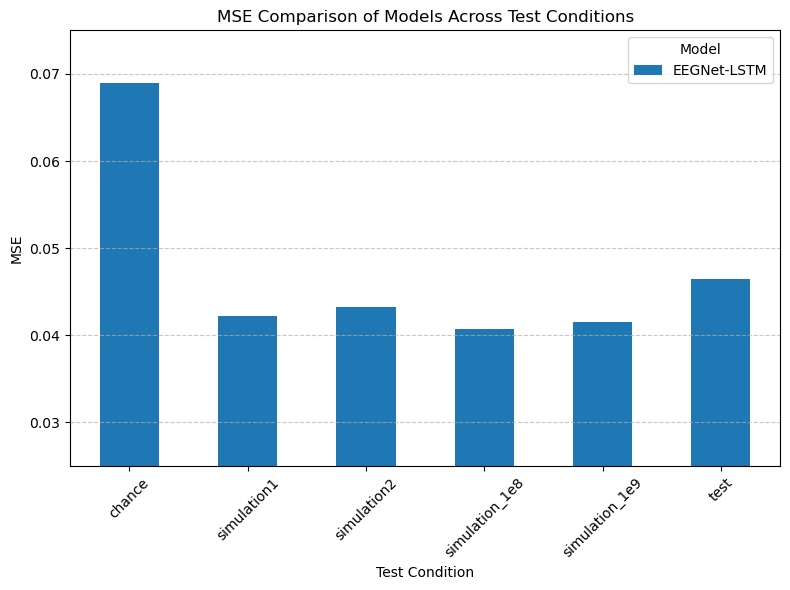

In [185]:
mse_df = pd.DataFrame({
    # 'EEG-MLP': {k: v['mse'] for k, v in eeg_mlp_results.items()},
    # 'EEGNet': {k: v['mse'] for k, v in eegnet_results.items()},
    'EEGNet-LSTM': {k: v['mse'] for k, v in eegnet_lstm_results.items()}
})

mse_df = mse_df.round(4)
mse_df = mse_df.sort_index()
mse_df

def unpack_single_element_list(x):
    return x[0] if isinstance(x, list) and len(x) == 1 else float('nan')

# 应用到整个 DataFrame
mse_df = mse_df.applymap(unpack_single_element_list)

# 转为 float 类型，保留 4 位小数
mse_df = mse_df.astype(float).round(4)

# 绘图
ax = mse_df.plot(kind='bar', figsize=(8, 6))

plt.title('MSE Comparison of Models Across Test Conditions')
plt.ylabel('MSE')
plt.xlabel('Test Condition')
plt.xticks(rotation=45)
plt.ylim(0.025, 0.075)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

/tmp/ipykernel_4945/2848225637.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mae_df = mae_df.applymap(unpack_single_element_list)


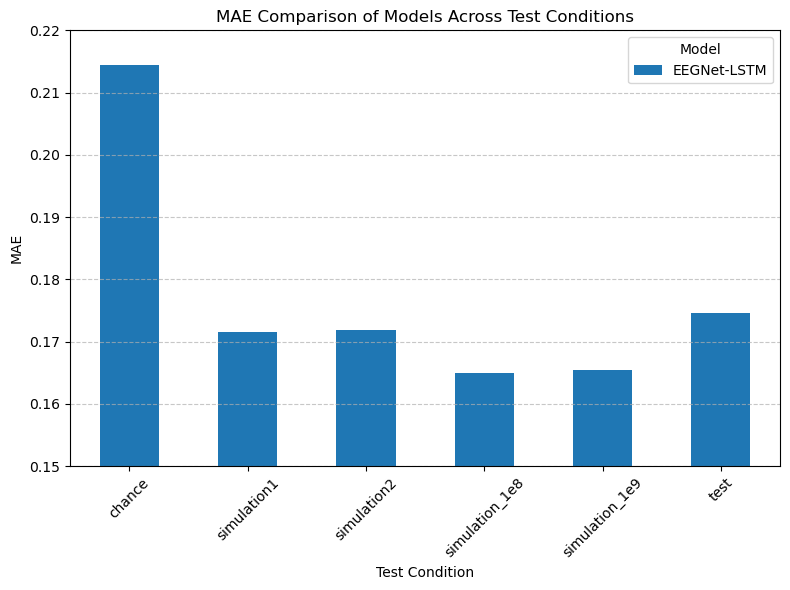

In [186]:
mae_df = pd.DataFrame({
    # 'EEG-MLP': {k: v['mae'] for k, v in eeg_mlp_results.items()},
    # 'EEGNet': {k: v['mae'] for k, v in eegnet_results.items()},
    'EEGNet-LSTM': {k: v['mae'] for k, v in eegnet_lstm_results.items()}
})

mae_df = mae_df.round(4)
mae_df = mae_df.sort_index()
mae_df

def unpack_single_element_list(x):
    return x[0] if isinstance(x, list) and len(x) == 1 else float('nan')

# 应用到整个 DataFrame
mae_df = mae_df.applymap(unpack_single_element_list)

# 转为 float 类型，保留 4 位小数
mae_df = mae_df.astype(float).round(4)

# 绘图
ax = mae_df.plot(kind='bar', figsize=(8, 6))

plt.title('MAE Comparison of Models Across Test Conditions')
plt.ylabel('MAE')
plt.xlabel('Test Condition')
plt.xticks(rotation=45)
plt.ylim(0.15, 0.22)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [187]:
ex_results_dir = './results'
os.makedirs(ex_results_dir, exist_ok=True)
mse_df.to_csv(f"{ex_results_dir}/mse_results_0514.csv")
mae_df.to_csv(f"{ex_results_dir}/mae_results_0514.csv")

In [188]:
mse_df = pd.read_csv("./results/mse_results_0514.csv", index_col=0)
mae_df = pd.read_csv("./results/mae_results_0514.csv", index_col=0)

print(mse_df)
print(mae_df)

                EEGNet-LSTM
chance               0.0690
simulation1          0.0422
simulation2          0.0432
simulation_1e8       0.0407
simulation_1e9       0.0415
test                 0.0465
                EEGNet-LSTM
chance               0.2144
simulation1          0.1716
simulation2          0.1718
simulation_1e8       0.1650
simulation_1e9       0.1655
test                 0.1746


# Plotting

In [ ]:
model_dir = "./checkpoints_cv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNetLSTMRegression().to(device)
model.load_state_dict(torch.load(f'{model_dir}/eegnet_lstm_best_model_fold_2_mse_0.0781.pth'))
model.eval

# simulation 1e8
data_path = "../data_simulation/aligned_data_simulation_1e8.npz"
temp_data = np.load(data_path, allow_pickle=True)
data = temp_data['arr_0']

if data.ndim == 0 and isinstance(data.item(), dict):
    structured_dict = data.item()
elif isinstance(data, np.ndarray) and data.size == 1 and isinstance(data[0], dict):
    structured_dict = data[0]
else:
    if isinstance(data, dict):
        structured_dict = data
    else:
        print("Unrecognized internal structure. Please check the exact type and content of data.")
        structured_dict = None

if structured_dict:
    timepoint_array = structured_dict['timepoint']
    feature_array = structured_dict['feature']
    steering_array = structured_dict['steering']
    location_array = structured_dict['location']
    velocity_array = structured_dict['velocity']
else:
    print("Failed to correctly extract the internal dictionary.")

simulation_1e8_data = z_score_norm(feature_array)
simulation_1e8_label = steering_array

data_dir = '../data/data_model/sub-jimingda/aligned_data_20250311'
data_s1 = np.load(data_dir + '/20240819_jmd_aligned_1.npz')
data_s3 = np.load(data_dir + '/20240819_jmd_aligned_3.npz')
data_s5 = np.load(data_dir + '/20240819_jmd_aligned_5.npz')
data_s7 = np.load(data_dir + '/20240819_jmd_aligned_7.npz')
feature_s1, steering_s1 = data_s1['feature'], data_s1['steering']
feature_s3, steering_s3 = data_s3['feature'], data_s3['steering']
feature_s5, steering_s5 = data_s5['feature'], data_s5['steering']
feature_s7, steering_s7 = data_s7['feature'], data_s7['steering']

# 定位s1弯道部分的index
bend_index = np.where(abs(steering_s1) > 0.05)

test_data = simulation_1e8_data[bend_index]
test_label = simulation_1e8_label[bend_index]

# DataLoader

test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), 
                             torch.tensor(test_label, dtype=torch.float32))

batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
preds = []
gts = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        output = model(x_batch)
        preds.append(output.cpu().numpy())
        gts.append(y_batch.numpy())

preds = np.concatenate(preds)
gts = np.concatenate(gts)

mse = mean_squared_error(gts, preds)
print(f'Test MSE: {mse:.4f}')

eval_result = evaluate_regression(model, test_data, test_label, params=["mse", "mae"])

Test MSE: 0.0407
mse = 0.0407
mae = 0.1650


In [178]:
test_data_chance = feature_s1[bend_index]
test_data_chance = z_score_norm(test_data_chance) 
test_label_chance = steering_s1[bend_index]

test_dataset_chance = TensorDataset(torch.tensor(test_data_chance, dtype=torch.float32), 
                             torch.tensor(test_label_chance, dtype=torch.float32))
batch_size = 64
test_loader_chance = DataLoader(test_dataset_chance, batch_size=batch_size, shuffle=False)

preds_chance = []
gts_chance = []

with torch.no_grad():
    for x_batch, y_batch in test_loader_chance:
        x_batch = x_batch.to(device)
        output = model(x_batch)
        preds_chance.append(output.cpu().numpy())
        gts_chance.append(y_batch.numpy())

preds_chance = np.concatenate(preds_chance)
gts_chance = np.concatenate(gts_chance)

mse = mean_squared_error(gts_chance, preds_chance)
print(f'Test MSE: {mse:.4f}')

eval_result = evaluate_regression(chance_model_EEGNetLSTM, test_data, test_label, params=["mse", "mae"])

Test MSE: 0.0374
mse = 0.0255
mae = 0.1229


In [139]:
scaling_factor = 2.6
preds = preds / scaling_factor

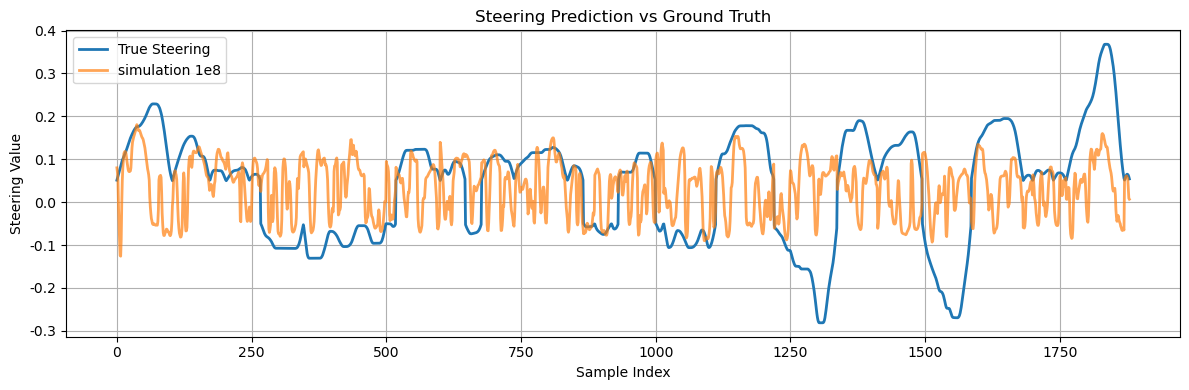

In [151]:
# 模拟数据解码和真实角度的对比
start = 800
end = 1000
plt.figure(figsize=(12, 4))
plt.plot(test_label, label='True Steering', linewidth=2)
plt.plot(preds, label='simulation 1e8', linewidth=2, alpha=0.7)
plt.title('Steering Prediction vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Steering Value')
plt.legend()
# plt.xlim(start, end)
# plt.ylim(-0.2,0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

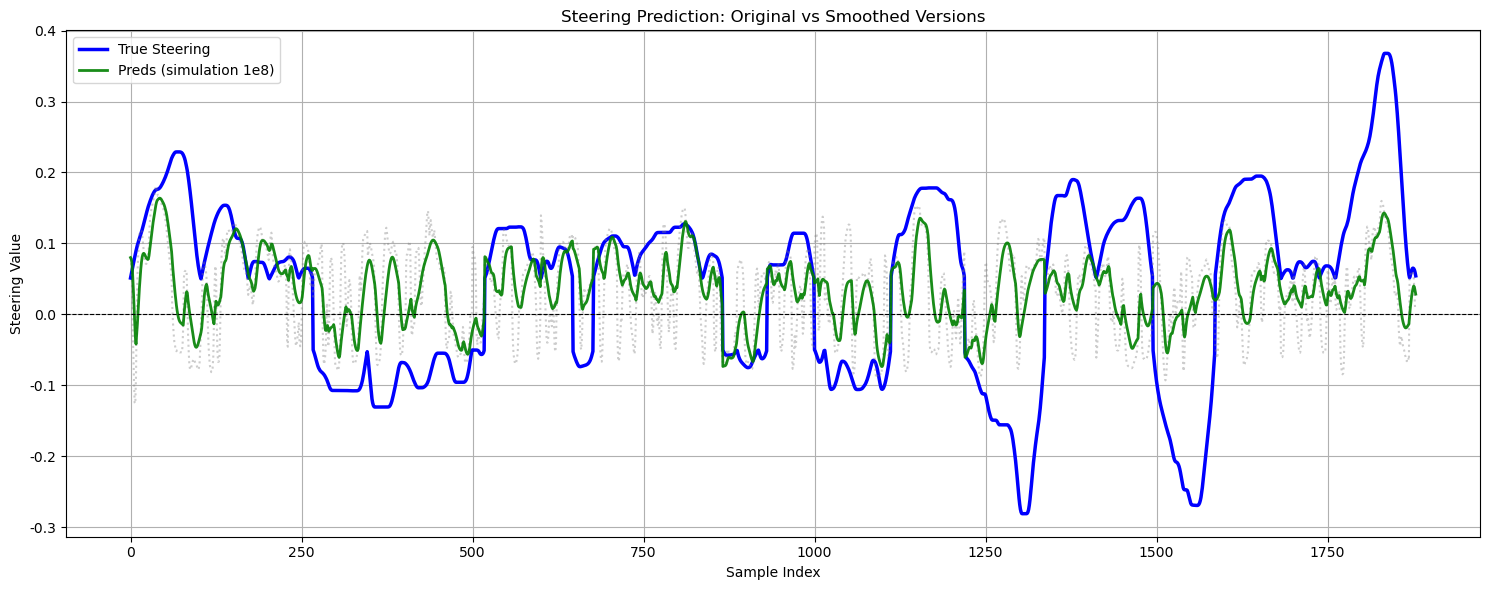

Segmented EMA (span=10) on Cond. Smoothed
MSE (Original Preds vs True): 0.0185
MSE (Conditionally Smoothed Preds vs True): 0.0145
MSE (Segmented EMA on Cond. Smoothed Preds vs True): 0.0135


In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def conditional_smoothing(preds_original, test_labels, window_size_ma):
    if len(preds_original) != len(test_labels):
        raise ValueError("preds_original 和 test_labels 的长度必须相同")
    if window_size_ma <= 0:
        raise ValueError("window_size_ma 必须是正整数")
    if window_size_ma > len(preds_original):
        return preds_original.copy()

    preds_flat = preds_original.flatten()
    test_labels_flat = test_labels.flatten()
    preds_ma = moving_average(preds_flat, window_size_ma)
    smoothed_preds = preds_flat.copy()
    offset = (window_size_ma - 1) // 2

    for i in range(len(preds_ma)):
        original_idx = i + offset
        if original_idx < len(test_labels_flat):
            p_orig = preds_flat[original_idx]
            t_label = test_labels_flat[original_idx]
            p_smooth_ma = preds_ma[i]
            if np.sign(p_orig) * np.sign(t_label) < 0:
                smoothed_preds[original_idx] = p_smooth_ma
    return smoothed_preds

def sign_consistent_exponential_smoothing(data_to_smooth, reference_labels, span):
    """
    分段指数平滑
    """
    if len(data_to_smooth) != len(reference_labels):
        raise ValueError("data_to_smooth 和 reference_labels 的长度必须相同.")
    if span <= 0:
        raise ValueError("span 必须是正整数.")

    smoothed_data = np.zeros_like(data_to_smooth, dtype=float)
    current_segment = []
    last_sign = 0 # 初始符号，0可以表示无符号或开始

    for i in range(len(data_to_smooth)):
        current_label_sign = np.sign(reference_labels[i])

        # 符号改变 (且不是从0变到有符号，或从有符号变到0，除非我们严格定义0也是一种符号)
        # 这里简化为：只要当前符号和上一个非零符号不同，就认为是一个新段的开始
        # 或者更简单：只要当前符号和上一个点的符号不同（即使是0），就重置。
        # 为了模拟“窗口内符号一致”，当reference_labels的符号从正到负或从负到正时，我们应该重置。
        # 0值的处理比较棘手，暂时将其视为可以中断同符号段。

        if i > 0 and np.sign(reference_labels[i-1]) != 0 and current_label_sign != 0 and np.sign(reference_labels[i-1]) != current_label_sign:
            # 如果上一个符号不是0，当前符号也不是0，且两者符号不同，则处理前一段
            if current_segment:
                segment_series = pd.Series(current_segment)
                smoothed_segment = segment_series.ewm(span=span, adjust=False).mean().to_numpy()
                start_index = i - len(current_segment)
                smoothed_data[start_index:i] = smoothed_segment
            current_segment = [] # 开始新段

        current_segment.append(data_to_smooth[i])
        # last_sign = current_label_sign # 更新上一个符号 (这种方式对于简单符号改变有效)

    # 处理最后一个剩余的段
    if current_segment:
        segment_series = pd.Series(current_segment)
        smoothed_segment = segment_series.ewm(span=span, adjust=False).mean().to_numpy()
        start_index = len(data_to_smooth) - len(current_segment)
        smoothed_data[start_index:] = smoothed_segment

    # 对于 reference_labels 中为0的点，我们可以选择不平滑或者使用前一个平滑值
    # 目前实现，如果0导致分段，它会被包含在某个段的开始或结尾。
    # 如果希望对 reference_labels 为0 的地方，preds 不进行平滑，可以增加额外逻辑：
    for i in range(len(data_to_smooth)):
        if reference_labels[i] == 0:
            smoothed_data[i] = data_to_smooth[i] # 如果test_label为0，则preds不平滑

    return smoothed_data


# --- 假设您已经有了 preds 和 test_label (确保它们是 NumPy 数组) ---
# preds_flat = ...
# test_label_flat = ...
if 'preds_flat' not in locals() or 'test_label_flat' not in locals():
    if preds.ndim > 1: preds_flat = preds.flatten()
    else: preds_flat = preds.copy()
    if test_label.ndim > 1: test_label_flat = test_label.flatten()
    else: test_label_flat = test_label.copy()


# 第一步：条件滑动平均平滑
window_size_ma_conditional = 20
preds_conditionally_smoothed = conditional_smoothing(preds_flat, test_label_flat, window_size_ma_conditional)

# 第二步：对条件平滑后的结果再进行分段指数平滑，参考 test_label_flat 的符号
span_ema_segmented = 10 # 指数平滑的span值
preds_double_smoothed_segmented = sign_consistent_exponential_smoothing(
    preds_conditionally_smoothed,
    test_label_flat, # 使用原始 test_label 的符号作为分段参考
    span_ema_segmented
)

# --- 绘图对比 ---
start_plot = 0
end_plot = len(test_label_flat)

plt.figure(figsize=(15, 6))
plt.plot(test_label_flat[start_plot:end_plot], label='True Steering', linewidth=2.5, color='blue')
plt.plot(preds_flat[start_plot:end_plot], label='', linewidth=1.5, alpha=0.4, linestyle=':', color='gray')
# plt.plot(preds_conditionally_smoothed[start_plot:end_plot], label=f'Cond. Smoothed (MA w={window_size_ma_conditional})', linewidth=2, alpha=0.6, color='orange')

# 假设您使用的是分段指数平滑后的 preds_double_smoothed_segmented
plt.plot(preds_double_smoothed_segmented[start_plot:end_plot], label=f'Preds (simulation 1e8)', linewidth=2, alpha=0.9, color='green')
# 如果您使用的是简单二次指数平滑，则是 preds_double_smoothed

# +++ 添加 y=0 的水平线 +++
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
# +++++++++++++++++++++++++++

plt.title('Steering Prediction: Original vs Smoothed Versions')
plt.xlabel('Sample Index')
plt.ylabel('Steering Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
if start_plot != 0 or end_plot != len(test_label_flat):
    plt.xlim(start_plot, end_plot)
# plt.ylim(-0.2,0.2) # 您可以根据数据的范围调整y轴限制
plt.show()

# print作图细节
print(f"Segmented EMA (span={span_ema_segmented}) on Cond. Smoothed")

# 评估MSE
mse_original = mean_squared_error(test_label_flat, preds_flat)
mse_conditional_smooth = mean_squared_error(test_label_flat, preds_conditionally_smoothed)
mse_double_smooth_segmented = mean_squared_error(test_label_flat, preds_double_smoothed_segmented)

print(f"MSE (Original Preds vs True): {mse_original:.4f}")
print(f"MSE (Conditionally Smoothed Preds vs True): {mse_conditional_smooth:.4f}")
print(f"MSE (Segmented EMA on Cond. Smoothed Preds vs True): {mse_double_smooth_segmented:.4f}")

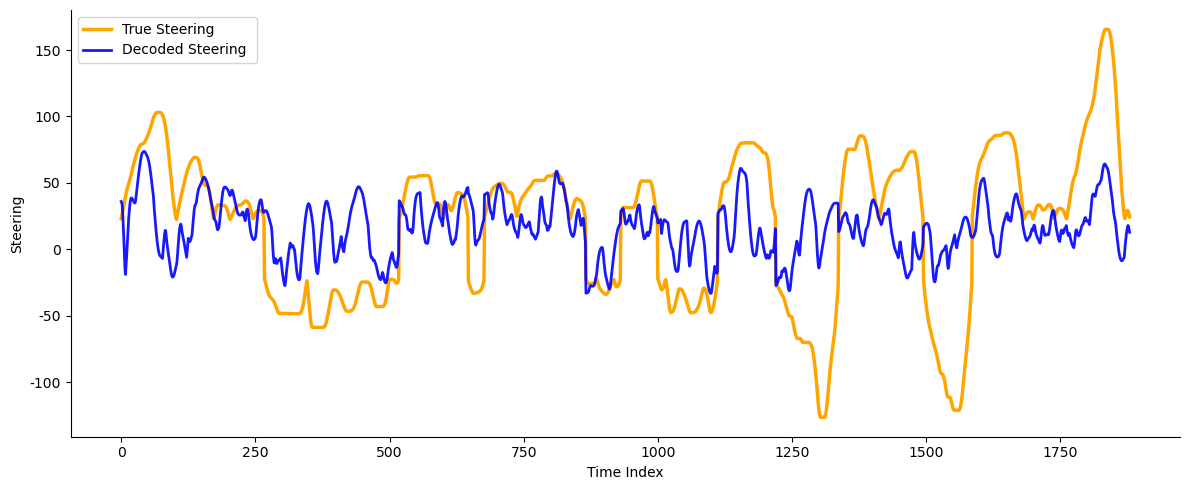

In [190]:
# --- 假设您已经有了 preds 和 test_label (确保它们是 NumPy 数组) ---
# preds_flat = ...
# test_label_flat = ...
if 'preds_flat' not in locals() or 'test_label_flat' not in locals():
    if preds.ndim > 1: preds_flat = preds.flatten()
    else: preds_flat = preds.copy()
    if test_label.ndim > 1: test_label_flat = test_label.flatten()
    else: test_label_flat = test_label.copy()


# 第一步：条件滑动平均平滑
window_size_ma_conditional = 20
preds_conditionally_smoothed = conditional_smoothing(preds_flat, test_label_flat, window_size_ma_conditional)

# 第二步：对条件平滑后的结果再进行分段指数平滑，参考 test_label_flat 的符号
span_ema_segmented = 10 # 指数平滑的span值
preds_double_smoothed_segmented = sign_consistent_exponential_smoothing(
    preds_conditionally_smoothed,
    test_label_flat, # 使用原始 test_label 的符号作为分段参考
    span_ema_segmented
)

# --- 乘以因子 ---
multiplication_factor = 450
test_label_plot = test_label_flat * multiplication_factor
preds_original_plot = preds_flat * multiplication_factor
preds_cond_smooth_plot = preds_conditionally_smoothed * multiplication_factor
preds_double_smooth_plot = preds_double_smoothed_segmented * multiplication_factor


# --- 绘图对比 ---
start_plot = 0
end_plot = len(test_label_plot)

fig, ax = plt.subplots(figsize=(12, 5)) # 获取 Axes 对象

# 绘制数据
ax.plot(test_label_plot[start_plot:end_plot], label='True Steering', linewidth=2.5, color='orange')
# 如果您还想绘制原始的解码角度作为参考，可以取消下面一行的注释
# ax.plot(preds_original_plot[start_plot:end_plot], label='Original Decoded ', linewidth=1.5, alpha=0.4, linestyle=':', color='gray')
ax.plot(preds_double_smooth_plot[start_plot:end_plot], label='Decoded Steering ', linewidth=2, alpha=0.9, color='blue')

# 添加 y=0 的水平线
# ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# 设置标题和标签
ax.set_title('')
ax.set_xlabel('Time Index')
ax.set_ylabel(f'Steering')
ax.legend()

# --- 去掉网格线和边框 ---
ax.grid(False) # 去掉网格线

# 去掉上边框和右边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 您可以选择保留左边框和下边框，或者也去掉它们
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# 如果要完全去掉边框和刻度，可以使用 ax.axis('off')，但这通常不太适合这类对比图

plt.tight_layout()
if start_plot != 0 or end_plot != len(test_label_plot):
    ax.set_xlim(start_plot, end_plot)
# ax.set_ylim(-90, 90) # 根据乘以450后的值域调整，例如，如果原始是-0.2到0.2
plt.savefig('simulation_1e8.pdf')


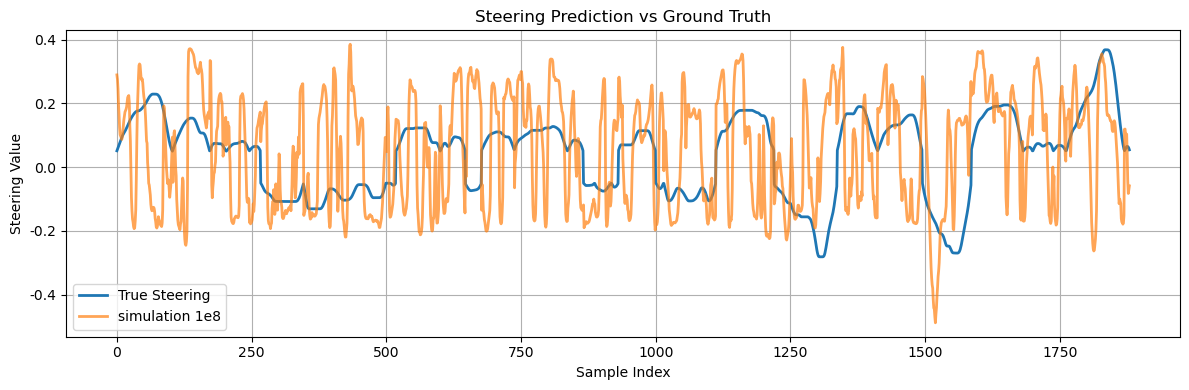

In [183]:
# 随机解码和真实角度的对比
start = 0
end = 1700
plt.figure(figsize=(12, 4))
plt.plot(test_label, label='True Steering', linewidth=2)
plt.plot(preds_chance, label='simulation 1e8', linewidth=2, alpha=0.7)
plt.title('Steering Prediction vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Steering Value')
plt.legend()
# plt.xlim(start, end)
# plt.ylim(-0.2,0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

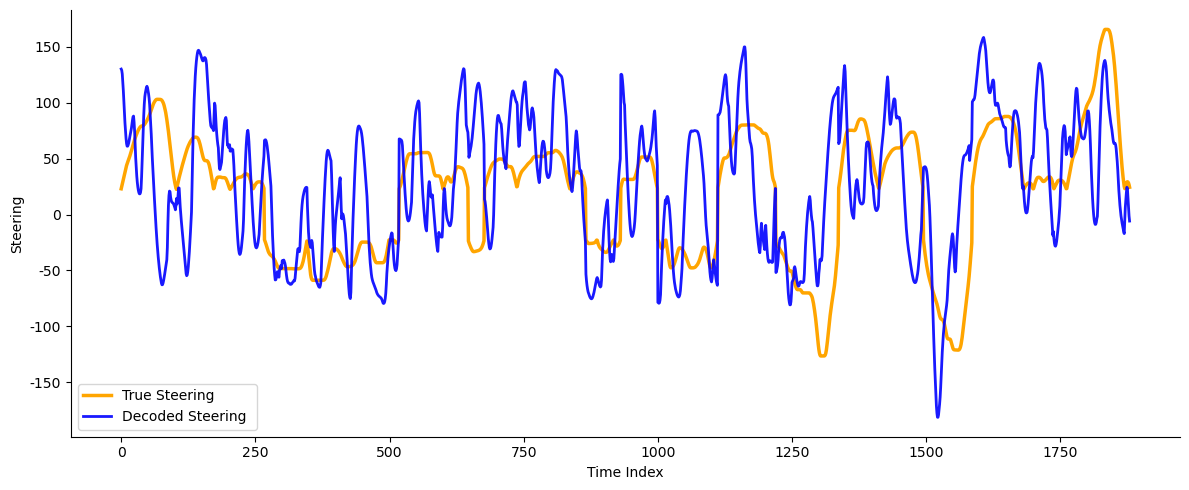

MSE (Original Preds vs True, original scale): 0.0374
MSE (Double Smoothed Preds vs True, original scale): 0.0184

MSE (Original Preds vs True, scaled by 450): 7580.7
MSE (Double Smoothed Preds vs True, scaled by 450): 3723.6


In [191]:
# --- 假设您已经有了 preds_chance 和 test_label (确保它们是 NumPy 数组) --- # <--- 修改注释
preds_chance_flat = preds_chance.flatten() if preds_chance.ndim > 1 else preds_chance.copy() # <--- 修改
test_label_flat = test_label.flatten() if test_label.ndim > 1 else test_label.copy() # <--- 修改

# 第一步：条件滑动平均平滑
window_size_ma_conditional = 20
preds_chance_conditionally_smoothed = conditional_smoothing(preds_chance_flat, test_label_flat, window_size_ma_conditional) # <--- 修改

# 第二步：对条件平滑后的结果再进行分段指数平滑，参考 test_label_flat 的符号
span_ema_segmented = 10 # 指数平滑的span值
preds_chance_double_smoothed_segmented = sign_consistent_exponential_smoothing( # <--- 修改
    preds_chance_conditionally_smoothed, # <--- 修改
    test_label_flat, 
    span_ema_segmented
)

# --- 乘以因子 ---
multiplication_factor = 450
test_label_plot = test_label_flat * multiplication_factor
preds_chance_original_plot = preds_chance_flat * multiplication_factor # <--- 修改
preds_chance_cond_smooth_plot = preds_chance_conditionally_smoothed * multiplication_factor # <--- 修改
preds_chance_double_smooth_plot = preds_chance_double_smoothed_segmented * multiplication_factor # <--- 修改


# --- 绘图对比 ---
start_plot = 0
end_plot = len(test_label_plot)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(test_label_plot[start_plot:end_plot], label='True Steering', linewidth=2.5, color='orange')
# ax.plot(preds_chance_original_plot[start_plot:end_plot], label='Original Decoded ', linewidth=1.5, alpha=0.4, linestyle=':', color='gray') # <--- 修改
ax.plot(preds_chance_double_smooth_plot[start_plot:end_plot], label='Decoded Steering ', linewidth=2, alpha=0.9, color='blue') # <--- 修改

# ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

ax.set_title('')
ax.set_xlabel('Time Index')
ax.set_ylabel(f'Steering')
ax.legend()

ax.grid(False) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
if start_plot != 0 or end_plot != len(test_label_plot):
    ax.set_xlim(start_plot, end_plot)

plt.savefig('chance.pdf')
plt.show()

# MSE评估
mse_original_scaled_labels = mean_squared_error(test_label_flat, preds_chance_flat) # <--- 修改
mse_double_smooth_scaled_labels = mean_squared_error(test_label_flat, preds_chance_double_smoothed_segmented) # <--- 修改
print(f"MSE (Original Preds vs True, original scale): {mse_original_scaled_labels:.4f}")
print(f"MSE (Double Smoothed Preds vs True, original scale): {mse_double_smooth_scaled_labels:.4f}")

mse_original_scaled_values = mean_squared_error(test_label_plot, preds_chance_original_plot) # <--- 修改
mse_double_smooth_scaled_values = mean_squared_error(test_label_plot, preds_chance_double_smooth_plot) # <--- 修改
print(f"\nMSE (Original Preds vs True, scaled by {multiplication_factor}): {mse_original_scaled_values:.1f}") 
print(f"MSE (Double Smoothed Preds vs True, scaled by {multiplication_factor}): {mse_double_smooth_scaled_values:.1f}")

